In [4]:
%%capture
import tensorflow as tf
import pprint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet.efficientnet_builder as efnet_builder
import efficientnet.efficientnet_model as efnet_model
# import util

# tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.ERROR)
# Set locale for printing (e.g. where to place integer separator ','s).
import locale
locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

# Sequential layers, class filter and contribution ranked feature pruning
The hypothesis is that the following three techniques can significantly reduce 
computation requirements of image classification neural networks:
  1. Compute a subset of the global average pool input (subset of 7x7 layer 
     output for EfficientNet). Sequentially compute outputs until classification 
     confidence is achieved.
  2. Determine the stochastic contributions of layer outputs to subsequent layer
     activations. Ignore inputs that don't meet a certain threshold. 
  3. Use a small sized network operating on a scaled down input image to 
     calculate with high accuracy the top 10 classes. This is hoped to reduce
     the need to compute features in the previous layers: compute only 50% of 
     2nd last layer outputs (feature layer), 75% of 3rd last layer, 87.5% of 4th
     last layer. The actual reduction relationship is not known.
     

## 1. Sequential pooling
If there is a reliable pattern of activation of layer 'block 15', the layer with
7x7xfiters outputs connecting to the global pool, this pattern could be used to
determine a subset of the 49 output 'pixels' \[What are the 'pixels' of the 
inner layers called?\] that can be computed with minimal effect on 
classification accuracy. 

More precisely, we could set a minimum required accuracy (in expectation) and
compute only a subset of the 49 pixels if one of the following sets of
functions can be well approximated. Each set needs to address 

### Stopping condition
We need a mapping from current activations to expected accuracy degradation. 
Pixels should continue to be calculated until the minimum expected accuracy is
reached. The available state data we have is the 49x1280 neuron outputs and the 
1280 pooled outputs. Possible mappings could be:

  1. g(num_pixels_evaluated | order) = accuracy_estimate
  2. total_pool_output = f(state data). g(total_pool_output) = accuracy_estimate
  3. f(pixels_evaluated) = contribution_estimate. g(contribution) = accuracy_estimate
  
An intermediate quantity that might be a good proxy for estimating accuracy is
the cross-entropy between the normal classification ouput and the perturbed 
classification output.
  
For the above 3 mappings, we would need to measure and parameterize the 
following distributions:

  1. (X, Y): (num pixels evaluated, accuracy | eval order)
  2. (X, Y): (total pool output, accuracy)
  3. (X, Z): (pixel, contribution), (Z, Y): (expected contribution sum, accuracy)
  
These distributions require the following information: 

  1. (correct classification?, num pixels evaluated)
  2. (correct classifciation?, total pool output)
  3. (correct classification?, percentage contribution)
          [49] (pixel, contribution)
  
  

### Pixel evaluation order
Which pixels should be calculated next so as to maximize accuracy. Naive orders
could be sequential from top-left to bottom right, or a random order.


### Dependency on class activations
With 1280 neurons connected densely to the pool layer, it is not feasible to 
calculate the 1280 class activations each time a pool value is updated. However,
if #3 above is implemented, the smaller number of considered classes would allow
the class activations to be computed multiple times without a significant effect 
on overall operation count. 


## Experiment 1: test sequential pooling with accuracy estimate based on the number of pixels evaluated
Success criteria: 
    * discover that dropping random pixels has minimal effect on the accuracy 
      for small drop counts.
    * extra: discover that some specific pixels have minimal effect on accuracy 
      (i.e. classification depends disproportionately on certain pixels).
      
      
Data collection
Run large number of evaluations (100,000). For every evaluation, run 49 extra
evaluations with 1 dropped pixel. 
results = [] 
for i in range 100,000:
    logits = run_eval()
    l = logit_for_correct(logits, ans)
    for j in range 49:
        for k in (0,1)
        mask = ave_mask if k else zero_mask
        mask_pixel(j, mask)
        logits = run_eval()
        results.append(j, mask, l, logit_for_correct(logits, ans), correct)
      
    

### Results (experiment id: 2.1.1)

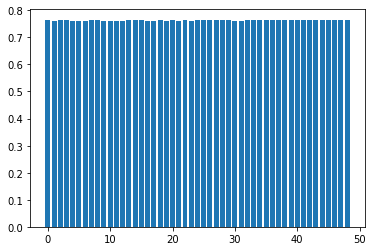

original accuracy: 0.75146484
max masked accuracy: 0.7651367
min masked accuracy: 0.76049805


In [11]:
res = {'accuracy': 0.75146484, 'mask_accuracy_18': 0.7624512, 'mask_accuracy_40': 0.76342773, 'mask_accuracy_26': 0.7631836, 'mask_accuracy_35': 0.7651367, 'mask_accuracy_29': 0.7624512, 'mask_accuracy_43': 0.76416016, 'mask_accuracy_27': 0.7626953, 'mask_accuracy_10': 0.76220703, 'mask_accuracy_16': 0.7619629, 'mask_accuracy_11': 0.76123047, 'mask_accuracy_46': 0.7636719, 'mask_accuracy_48': 0.76342773,  'mask_accuracy_2': 0.7631836, 'mask_accuracy_31': 0.7619629, 'mask_accuracy_37': 0.7644043, 'mask_accuracy_36': 0.76464844, 'mask_accuracy_23': 0.76171875, 'mask_accuracy_47': 0.76293945, 'mask_accuracy_45': 0.7644043, 'mask_accuracy_34': 0.7626953, 'mask_accuracy_38': 0.76464844, 'mask_accuracy_0': 0.7626953, 'mask_accuracy_30': 0.76220703, 'mask_accuracy_20': 0.7626953, 'mask_accuracy_1': 0.7609863, 'mask_accuracy_22': 0.7624512, 'mask_accuracy_39': 0.7644043, 'mask_accuracy_24': 0.7624512, 'mask_accuracy_8': 0.7626953, 'mask_accuracy_6': 0.7607422, 'mask_accuracy_7': 0.76342773, 'mask_accuracy_13': 0.7624512, 'mask_accuracy_19': 0.76171875, 'mask_accuracy_25': 0.76293945, 'mask_accuracy_9': 0.7619629, 'mask_accuracy_14': 0.7631836, 'mask_accuracy_28': 0.76293945, 'mask_accuracy_44': 0.76464844, 'mask_accuracy_17': 0.7619629, 'mask_accuracy_33': 0.7631836, 'mask_accuracy_15': 0.76293945, 'mask_accuracy_5': 0.76049805, 'mask_accuracy_42': 0.76464844, 'mask_accuracy_32': 0.7636719, 'mask_accuracy_3': 0.7624512, 'mask_accuracy_4': 0.76123047, 'mask_accuracy_21': 0.76171875, 'mask_accuracy_41': 0.763916, 'mask_accuracy_12': 0.76171875}
masked_accuracies = tuple(res['mask_accuracy_' + str(a)] for a in range(49))
plt.bar(range(49), masked_accuracies)
plt.show()
print(f'original accuracy: {res["accuracy"]}')
print(f'max masked accuracy: {max(masked_accuracies)}')
print(f'min masked accuracy: {min(masked_accuracies)}')

### Conclusion
Zero-ing a single pixel in the 7x7 grid of features consistently produces higher accuracy.

This is a strange result, one that raises the question: was the
experiment flawed?

# Notes
Maybe PCA is a way to get some measures that don't ignore the dependencies 
between different neuron outputs. 